# Experiment 2: GMM Clustering

## Imports and Configuration

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.gmm import GMM, Covariance
from src.utils.metrics import *
from src.utils.utils import *

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Data Loading and Preprocessing

In [106]:
X_scaled, y_true = load_scale_data(data_path=os.path.abspath('./data/breast_cancer.csv'))

print(f"Dataset shape: {X_scaled.shape}")
print(f"Labels shape: {y_true.shape}")

Dataset shape: (569, 30)
Labels shape: (569,)


## Finding Optimal Components using BIC and AIC

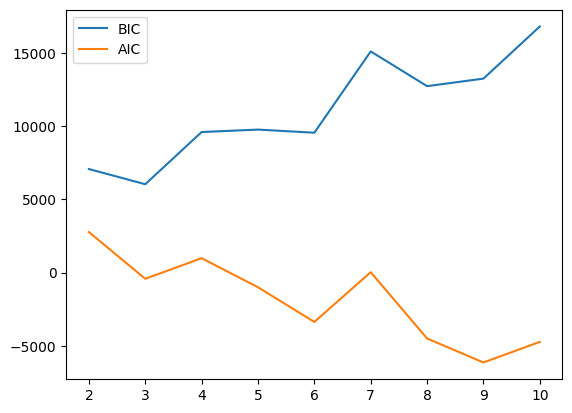

In [127]:
k_range = range(2, 11)
bic_scores = []
aic_scores = []

for k in k_range:
    gmm = GMM(k=k, covariance_type=Covariance.FULL)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

plt.plot(k_range, bic_scores, label='BIC')
plt.plot(k_range, aic_scores, label='AIC')
plt.legend()
plt.show()

## Comparing Covariance Types

```Plots```

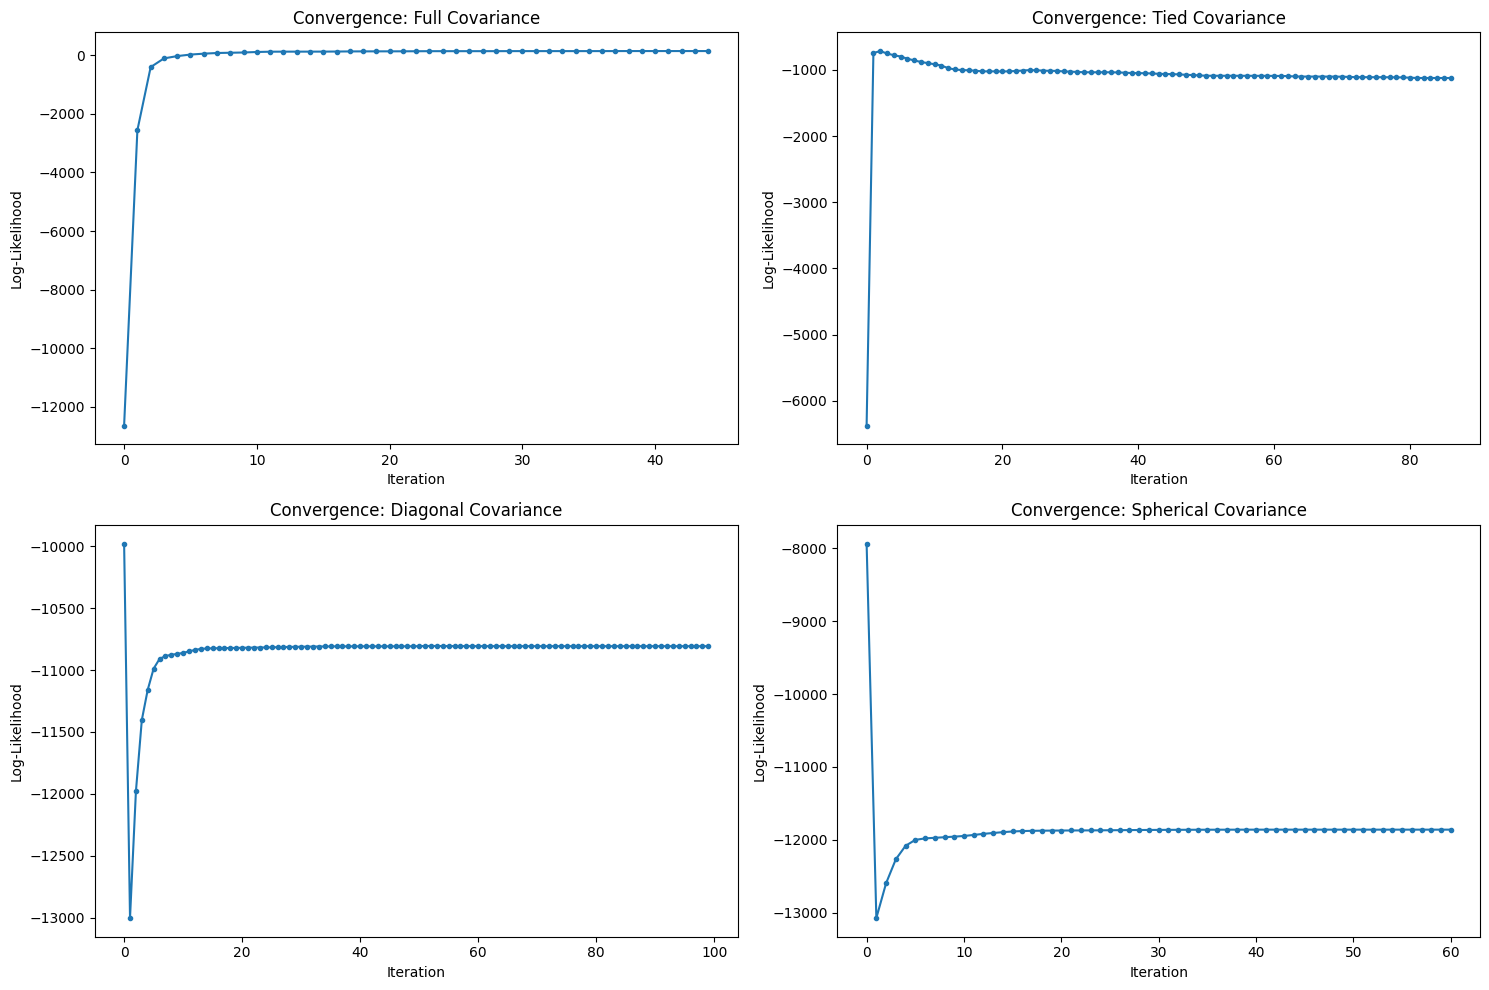

In [128]:
optimal_k = 2

cov_types = [Covariance.FULL, Covariance.TIED, Covariance.DIAGONAL, Covariance.SPHERICAL]
results = {}

plt.figure(figsize=(15, 10))

for i, cov_type in enumerate(cov_types):
    start_time = time.time()
    gmm = GMM(k=optimal_k, covariance_type=cov_type, max_iter=100, tol=1e-4)
    gmm.fit(X_scaled)
    elapsed_time = time.time() - start_time
    
    results[cov_type.value] = {
        'Final Log-Likelihood': gmm.log_likelihood_[-1],
        'Iterations': len(gmm.log_likelihood_),
        'Time (s)': elapsed_time,
        'BIC': gmm.bic(X_scaled),
        'AIC': gmm.aic(X_scaled)
    }
    
    # Plot Log-Likelihood Convergence
    plt.subplot(2, 2, i+1)
    plt.plot(gmm.log_likelihood_, marker='.')
    plt.title(f"Convergence: {cov_type.value.capitalize()} Covariance")
    plt.xlabel("Iteration")
    plt.ylabel("Log-Likelihood")

plt.tight_layout()
plt.show()

```Comparison Table```

In [129]:
df_results = pd.DataFrame(results).T
print("Covariance Type Comparison:")
print(df_results)

Covariance Type Comparison:
           Final Log-Likelihood  Iterations  Time (s)           BIC  \
full                 142.140014        45.0  0.041539   6002.505482   
tied               -1123.321370        87.0  0.081475   5583.523848   
diagonal          -10806.975720       100.0  0.085455  22381.560973   
spherical         -11859.196384        61.0  0.046510  24118.057235   

                    AIC  
full        1697.719972  
tied        3298.642739  
diagonal   21855.951440  
spherical  23844.392768  


## GMM Performance Analysis

### Select the Best Model

In [130]:
best_cov = df_results['BIC'].idxmin()
print(f"Analyzing Best Model: {best_cov} covariance")

best_gmm = GMM(k=optimal_k, covariance_type=Covariance(best_cov))
best_gmm.fit(X_scaled)
y_gmm_pred = best_gmm.predict(X_scaled)

Analyzing Best Model: tied covariance


### Internal Validation Metrics

In [131]:
sil_score = compute_silhouette_score(X_scaled, y_gmm_pred)
print(f"Internal Metrics:")
print(f" - Silhouette Score: {sil_score:.4f}")
print(f" - Final Log-Likelihood: {best_gmm.log_likelihood_[-1]:.4f}")
print(f" - BIC: {best_gmm.bic(X_scaled):.4f}")

Internal Metrics:
 - Silhouette Score: 0.1935
 - Final Log-Likelihood: -846.4731
 - BIC: 5029.8273


### External Validation Metrics

In [132]:
# Map GMM clusters to true labels
y_gmm_aligned = align_clusters_with_labels(y_true, y_gmm_pred)

purity = purity_score(y_true, y_gmm_aligned)

print(f"\nExternal Metrics (Labels used for evaluation only):")
print(f" - Purity: {purity:.4f}")


External Metrics (Labels used for evaluation only):
 - Purity: 0.7575


### Cluster assignments on 2D Projections

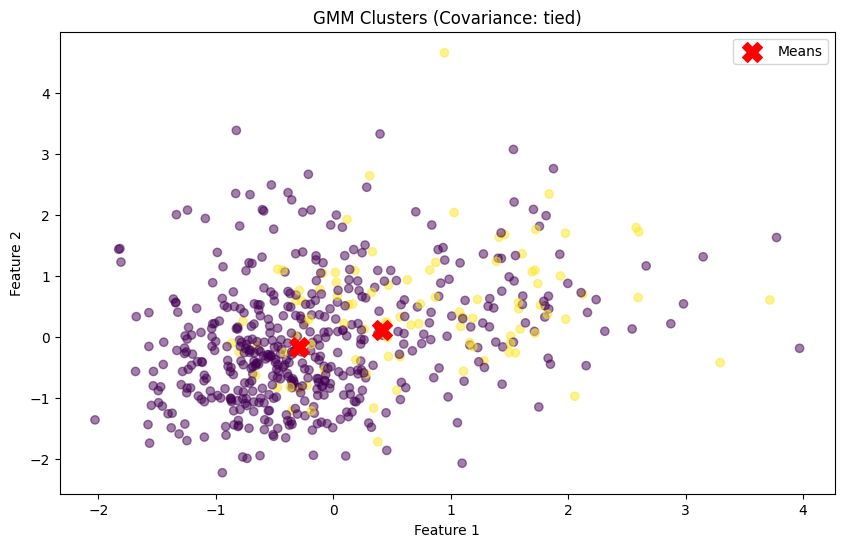

In [133]:
plt.figure(figsize=(10, 6))
# Using first two features for 2D visualization
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_gmm_pred, cmap='viridis', alpha=0.5)
plt.scatter(best_gmm.mu[:, 0], best_gmm.mu[:, 1], c='red', marker='X', s=200, label='Means')
plt.title(f"GMM Clusters (Covariance: {best_cov})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

### Confusion Matrix Analysis

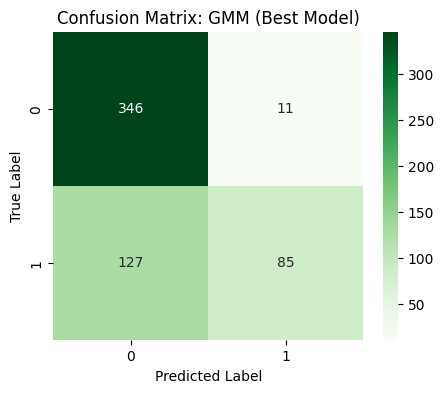

In [134]:
cm_gmm = compute_confusion_matrix(y_true, y_gmm_aligned)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_gmm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix: GMM (Best Model)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()